## Paper Title: Human level context understanding of social media posts

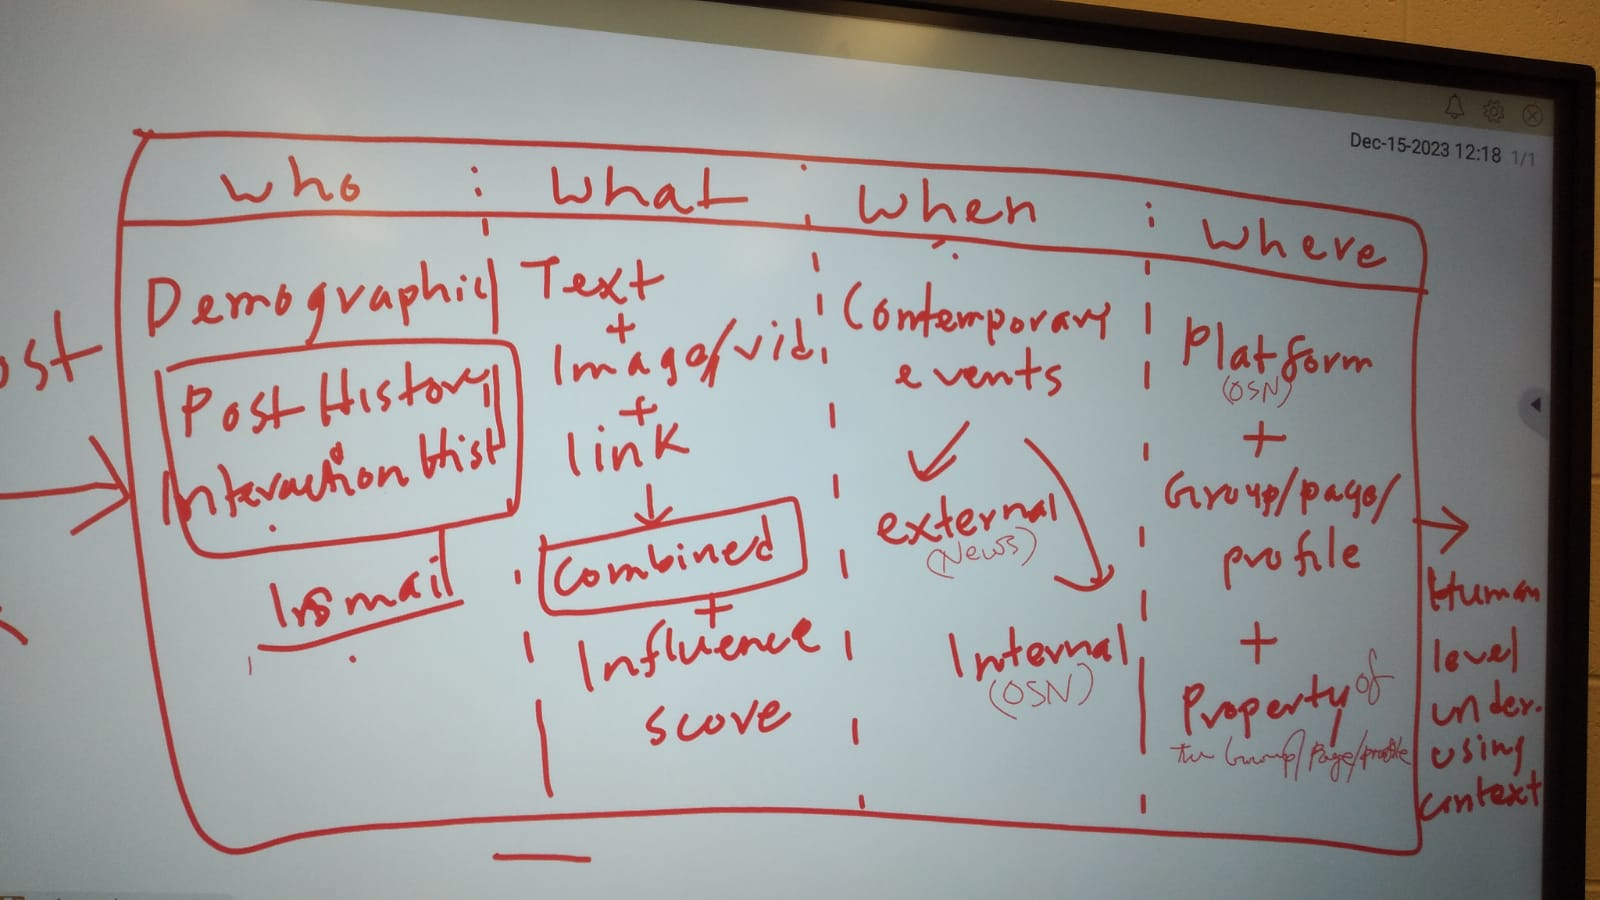

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, AdamW
from torch.utils.data import DataLoader, Dataset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
filepath = "/content/test.csv"

In [ ]:
import pandas as pd
df = pd.read_csv(filepath)

In [ ]:
df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


In [ ]:
# prompt: from the above df create a list of tuple, first item will be the article and second will be the highlights
dataset = list(zip(df['article'], df['highlights']))

In [ ]:
len(dataset)

11490

## Split the dataset into training and validation sets

In [ ]:
train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=42)

In [ ]:
("train data length: ", len(train_data))

('train data length: ', 10341)

In [ ]:
"val data length: ", len(val_data)

('val data length: ', 1149)

In [ ]:
class SummarizationDataset(Dataset):
    def __init__(self, tokenizer, data):
        self.tokenizer = tokenizer
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        source_text, target_summary = self.data[idx]
        source_encoding = self.tokenizer(source_text, return_tensors='pt', truncation=True, padding=True)
        target_encoding = self.tokenizer(target_summary, return_tensors='pt', truncation=True, padding=True)
        return {
            'input_ids': source_encoding['input_ids'].squeeze(),
            'attention_mask': source_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

## Initialize the BERT model and tokenizer

In [ ]:
# For more advanced summarization, consider using models like BART or T5
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Initialize the dataset and data loaders

In [ ]:
train_dataset = SummarizationDataset(tokenizer, train_data)
val_dataset = SummarizationDataset(tokenizer, val_data)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

## Set up training parameters

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 2

## Train model

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for batch in tqdm(val_loader, desc=f'Validation - Epoch {epoch + 1}'):
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)
    average_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch + 1} - Avg Train Loss: {average_train_loss:.4f}, Avg Val Loss: {average_val_loss:.4f}')

## Save the trained model

In [ ]:
model.save_pretrained('bert_summarization_model')
tokenizer.save_pretrained('bert_summarization_model')